<a href="https://colab.research.google.com/github/joyfulspace/Books/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C/ch3_%ED%8F%89%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch3. 정확도

In [1]:
!git clone https://github.com/joyfulspace/Books.git

Cloning into 'Books'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 51 (delta 12), reused 21 (delta 2), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [2]:
Path = '/content/Books/파이썬머신러닝완벽가이드/data'

### 데이터가 불균형하면 예측 성능과 상관없이 정확도가 높게 나올 수 있다.

In [3]:
import numpy as np
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  # fit() 메소드는 아무것도 학습하지 않음.
  def fit(self, X, y=None):
    pass

  # predict() 메소드는 단순히 Sex feature가 1이면, 0
  # , 그렇지 않으면 1로 예측
  def predict(self, X):
    pred = np.zeros((X.shape[0], 1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i]==1:
        pred[i] = 0
      else:
        pred[i] = 1

    return pred

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
  return df

# 레이블 인코딩 수행.
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])

  return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할.
titanic_df = pd.read_csv(f'{Path}/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용하여 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
acc = accuracy_score(y_test, mypredictions)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(acc))

Dummy Classifier의 정확도는: 0.7877


In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass
  
  # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self, X):
    return np.zeros( (len(X),1), dtype=bool)

# 사이킷런의 내장 데이터 셋인 load_digits()를 이용하여 MNIST 데이터 로딩
digits = load_digits()

# digits번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 
# 7번이 아니면 False이고 0으로 변환.
y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, \
                                                    random_state=11)

In [7]:
# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
fakeacc = accuracy_score(y_test, fakepred)
print('모든 예측을 0으로 하여도 정확도는: {:.3f}'.format(fakeacc))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900


###  불균형 데이터에서는 아래 지표들을 사용해야 함
## 3-2 Confusion Matrix

In [8]:
from sklearn.metrics import confusion_matrix

# 앞절의 예측 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix 출력
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

## 3-3 Precision과 Recall
* Precision 정밀도: 실제 Negative 데이터를 Positive로 잘못 예측하면 큰 영향이 발생하는 경우 중요 ex) 스팸메일
* Recall 재현율: 실제 Positive 데이터를 Negative로 잘못 판단하면 큰 영향이 발생하는 경우 중요. ex) 암 판단, 보험 사기

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 오차행렬, 정확도, 정밀도, 재현율을 한꺼번에 계산하는 함수 생성
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [10]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
# solver: 최적화 알고리즘
# liblinear: 작은 데이터 세트의 이진 분류
# lbfgs: 데이터 세트가 크고 다중 분류

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[401   4]
 [  2  43]]
정확도: 0.9867, 정밀도: 0.9149, 재현율: 0.9556


### Precision/Recall Trade-off
* 분류 결정 임곗값을 조정해 수치 변경 가능
* 상호 보완적인 평가 지표라서 한 지표를 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움


In [11]:
# predict_proba: 개별 데이터별로 예측 확률 반환.
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출\n:', pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 concatenate하여 
# 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두개의 class중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba()결과 Shape: (450, 2)
pred_proba array에서 앞 3개만 샘플로 추출
: [[9.99999971e-01 2.86168552e-08]
 [9.79518260e-01 2.04817399e-02]
 [9.99999841e-01 1.58523299e-07]]
두개의 class중에서 더 큰 확률을 클래스 값으로 예측
 [[9.99999971e-01 2.86168552e-08 0.00000000e+00]
 [9.79518260e-01 2.04817399e-02 0.00000000e+00]
 [9.99999841e-01 1.58523299e-07 0.00000000e+00]]


In [12]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [13]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두번째 컬럼, 즉 Positive 클래스 컬럼 하나만 추출
pred_proba_1 = pred_proba[:,1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[401   4]
 [  2  43]]
정확도: 0.9867, 정밀도: 0.9149, 재현율: 0.9556


In [14]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[400   5]
 [  2  43]]
정확도: 0.9844, 정밀도: 0.8958, 재현율: 0.9556


In [15]:
# 여러개의 분류 결정 임곗값을 변경하면서 Binarizer를 이용하여 예측값 변환
# 테스트를 수행할 모든 임곗값
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[400   5]
 [  2  43]]
정확도: 0.9844, 정밀도: 0.8958, 재현율: 0.9556
임곗값: 0.45
오차 행렬
[[401   4]
 [  2  43]]
정확도: 0.9867, 정밀도: 0.9149, 재현율: 0.9556
임곗값: 0.5
오차 행렬
[[401   4]
 [  2  43]]
정확도: 0.9867, 정밀도: 0.9149, 재현율: 0.9556
임곗값: 0.55
오차 행렬
[[401   4]
 [  2  43]]
정확도: 0.9867, 정밀도: 0.9149, 재현율: 0.9556
임곗값: 0.6
오차 행렬
[[401   4]
 [  2  43]]
정확도: 0.9867, 정밀도: 0.9149, 재현율: 0.9556


In [16]:
from sklearn.metrics import precision_recall_curve
# 임계값에 따른 정밀도-재현율 값 추출

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 
# precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print('thresholds 5 sample:', thresholds[:5])
print('precisions 5 sample:', precisions[:5])
print('recalls 5 sample:', recalls[:5])

# 반환된 임계값 배열 로우가 81건이므로 샘플로 10건만 추출하되, 
# 임곗값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (80,)
반환된 precisions 배열의 Shape: (81,)
반환된 recalls 배열의 Shape: (81,)
thresholds 5 sample: [0.00040359 0.0004099  0.00043461 0.00046522 0.00047751]
precisions 5 sample: [0.5625     0.55696203 0.56410256 0.57142857 0.57894737]
recalls 5 sample: [1.         0.97777778 0.97777778 0.97777778 0.97777778]
샘플 추출을 위한 임계값 배열의 index 10개: [ 0 15 30 45 60 75]
샘플용 10개의 임곗값: [0.   0.   0.09 1.   1.   1.  ]
샘플 임계값별 정밀도: [0.562 0.677 0.88  1.    1.    1.   ]
샘플 임계값별 재현율: [1.    0.978 0.978 0.778 0.444 0.111]


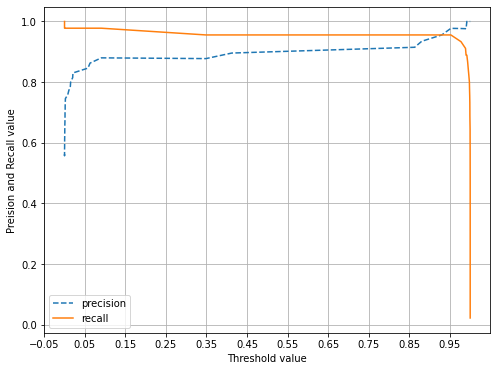

In [17]:
# 임계값의 변경에 따른 정밀도-재현율 변화 곡선을 그림
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축을 정밀도, 재현율 값으로 각각 Plot 수행. 
  # 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # X축, Y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value')
  plt.ylabel('Preision and Recall value')
  plt.legend()
  plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

## 3.4 F1 Score
* 재현율과 정밀도 결합한 수치

In [18]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.9348


In [19]:
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)

  # F1스코어 추가
  f1 = f1_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[400   5]
 [  2  43]]
정확도: 0.984444, 정밀도: 0.8958, 재현율: 0.9556, F1:0.9247
임곗값: 0.45
오차 행렬
[[401   4]
 [  2  43]]
정확도: 0.986667, 정밀도: 0.9149, 재현율: 0.9556, F1:0.9348
임곗값: 0.5
오차 행렬
[[401   4]
 [  2  43]]
정확도: 0.986667, 정밀도: 0.9149, 재현율: 0.9556, F1:0.9348
임곗값: 0.55
오차 행렬
[[401   4]
 [  2  43]]
정확도: 0.986667, 정밀도: 0.9149, 재현율: 0.9556, F1:0.9348
임곗값: 0.6
오차 행렬
[[401   4]
 [  2  43]]
정확도: 0.986667, 정밀도: 0.9149, 재현율: 0.9556, F1:0.9348


## 3-5 ROC Curve와 AUC

In [21]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열에서 샘플로 데이터를 추출하되, 임계값을 5 Step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값:', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index 10개: [1 6]
샘플용 10개의 임계값: [1.   0.09]
샘플 임계값별 FPR: [0.    0.015]
샘플 임계값별 TPR: [0.022 0.978]


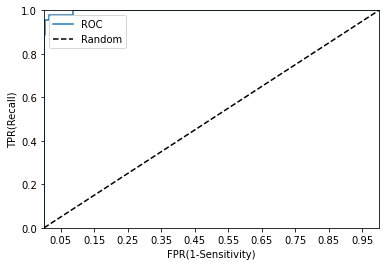

In [26]:
def roc_curve_plot(y_test, pred_proba_c1):
  # 임계값에 따른 FPR, TPR 값을 반환 받음
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  # ROC 곡선을 그래프 곡선으로 그림.
  plt.plot(fprs, tprs, label='ROC')
  # 가운데 대각선 직선을 그림.
  plt.plot([0, 1], [0, 1], 'k--', label='Random')

  # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('FPR(1-Sensitivity)')
  plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

In [28]:
from sklearn.metrics import roc_auc_score
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9976


In [29]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)

  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
         F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))